In [61]:
# 파이썬 시각화 패키지 불러오기
import matplotlib.pyplot as plt
%matplotlib inline


# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
import scipy as sp
import scipy.stats

sns.set_style('whitegrid')

## 잔차 정규성

확률론적 선형회귀 모형의 가정 중 하나는 **선형 정규 분포 가정**이다.

이는 종속변수 $y$가 독립변수 $x$와의 선형조합으로 결정되는 기댓값과 고정된 분산$\sigma^2$을 가지는 **가우시안 정규분포**를 따른다는 가정이다.

즉, 데이터가 이 가정을 만족한다면 분석결과로 나온 잔차는 정규분포를 따라야하며
 회귀분석이 제대로 진행되었다면 잔차는 회귀분석의 찌꺼기로 더 이상 예측할 수 있는 여지가 없어야한다. 

아래의 2차 비선형 관계를 가지는 데이터를 선형 모형으로 회귀 분석한 경우 어떤 문제가 발생하는지 살펴보자.

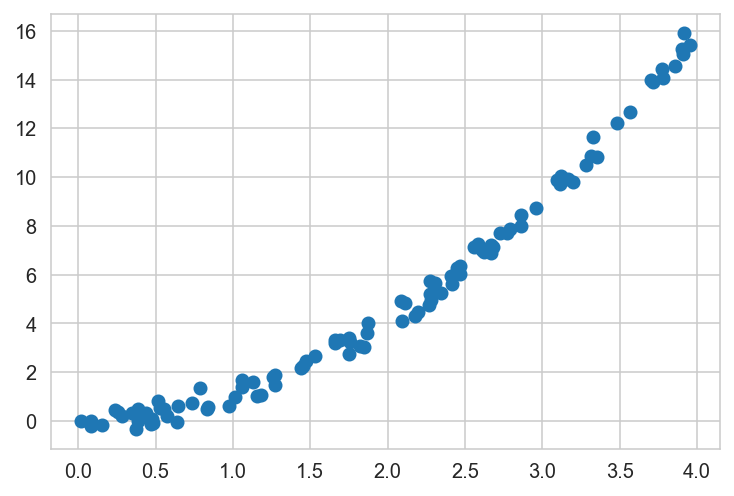

In [11]:
def make_regression2(n_sample=100, bias=0, noise=0.3, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 4
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x, y = make_regression2()
plt.scatter(x, y)
plt.show()

In [12]:
dfX0 = pd.DataFrame(x, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy2, dfX2)
result = model.fit()

Q-Q 플롯을 이용해 잔차의 정규성을 확인한 결과 직관적으로 정규분포를 따르지 않는 모습을 확인할 수 있다.

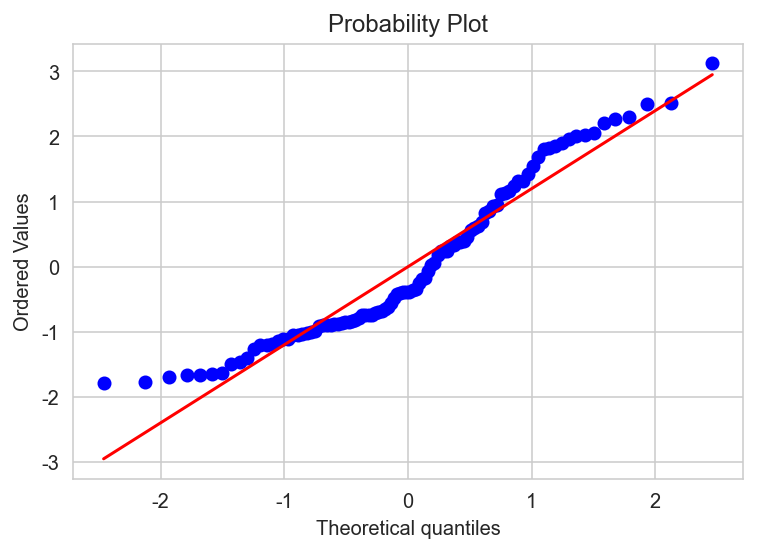

In [14]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

수치적인 정규성 검정을 위해 옴니버스 정규성 검정을 수행한 결과 역시 유의확률이 0.009로 정규분포를 따른다는 귀무가설을 기각한다.

In [15]:
test = sm.stats.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  9.520
P-value     :  0.009


이처럼 잔차에 대한 정규성 검정 결과가 기각되는 경우 1차적으로는 data가 비선형인지부터 확인하는 것이 바람직하다. 하지만 무조건적인 법칙은 아니므로 $x$에 따른 잔차를 직접 확인해봐야한다.

이러한 경우의 해결방법으로는 다항 선형회귀를 이용해 데이터를 변형하여 해결할 수 있다.($x$를 다항식으로 변형)

## 잔차와 독립변수의 관계

아래의 데이터는 2차 함수 관계를 따르는 선형 모형을 따르지 않는 데이터이다.

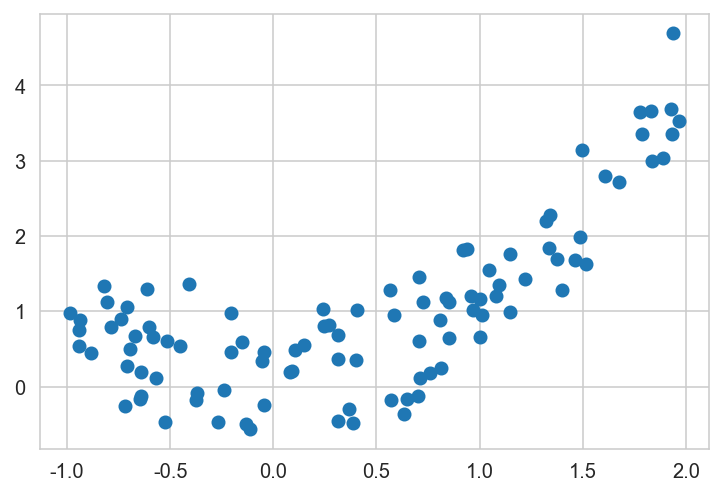

In [16]:
def make_regression3(n_sample=100, bias=0, noise=0.5, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 3 - 1
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x3, y3 = make_regression3()
plt.scatter(x3, y3)
plt.show()

In [17]:
dfX30 = pd.DataFrame(x3, columns=["X1"])
dfX3 = sm.add_constant(dfX30)
dfy3 = pd.DataFrame(y3, columns=["y"])

model3 = sm.OLS(dfy3, dfX3)
result3 = model3.fit()

이 데이터의 경우 Q-Q 플롯과 옴니버스 검정을 통해 정규성을 확인한 결과 정규분포를 따른다고 할 수 있다.

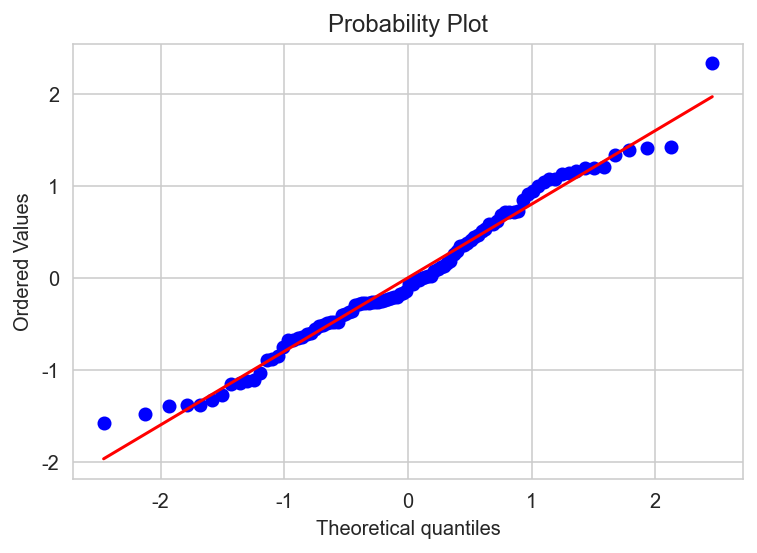

In [18]:
sp.stats.probplot(result3.resid, plot=plt)
plt.show()

In [19]:
test = sm.stats.omni_normtest(result3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  1.202
P-value     :  0.548


이처럼 데이터가 모형 가정을 따르지 않지만 정규 분포를 따르는 경우는 잔차와 독립변수간의 관계를 살펴보는 것이 바람직하다.

실제로 아래의 잔차와 독립변수의 시각화 결과를 확인하면 잔차가 독립변수와 어떠한 상관관계를 가지는 것을 확인할 수 있고 이 경우 올바른 모형으로 회귀분석이 되지 않았다는 것이다.

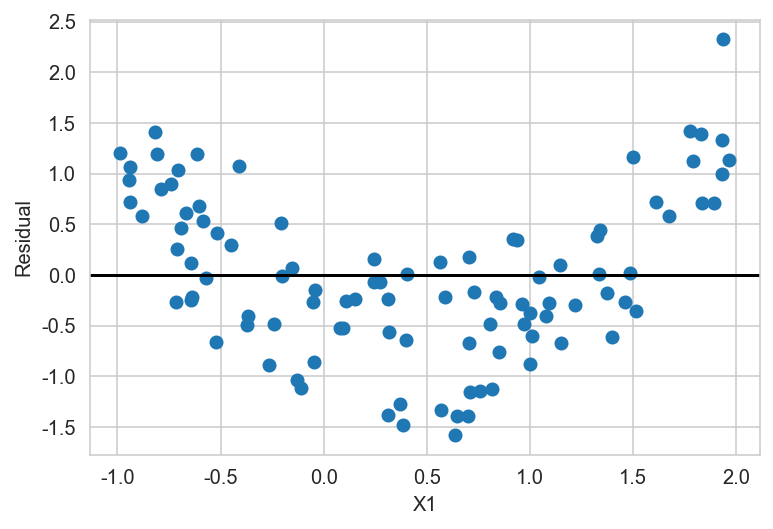

In [20]:
plt.plot(x3, result3.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

# 이분산성

확률론적 선형회귀 모형의 가정으로는 종속변수의 분산은 독립변수와 관계없이 어떤 고정된 값을 가진다. 하지만 실제 데이터 중에는 독립변수의 크기가 커지면 종속변수의 분산이 커지는 **이분산성(heteroskedastic)**문제가 발생하는 경우가 있다.

이 경우는 모든 sample의 잡음($\epsilon$)이 같지 않다는 것을 의미한다.

이분산성을 해결하는 방법으로는 종속변수에 로그를 취하는 것으로 translog 모형을 사용할 수 있다.

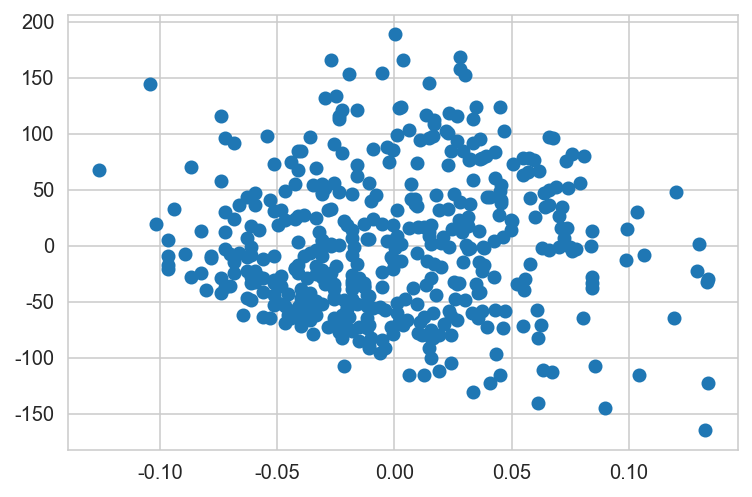

In [21]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
df = pd.concat([pd.DataFrame(diabetes.data, columns=["x%d" % (i + 1) for i in range(diabetes.data.shape[1])]),
                pd.DataFrame(diabetes.target, columns=["target"])],
               axis=1)
model = sm.OLS.from_formula("target ~ x9", data=df)
result = model.fit()
plt.scatter(df["x9"], result.resid)
plt.show()

# 비선형 변형

독립변수와 종속변수간의 관계가 비선형인 경우 이 둘의 관계를 선형으로 바꿀 수 있도록 독립변수를 비선형 변환하는 것이 가능하다.

아래는 Boston 데이터의 집값과 LSTAT과의 관계이다.

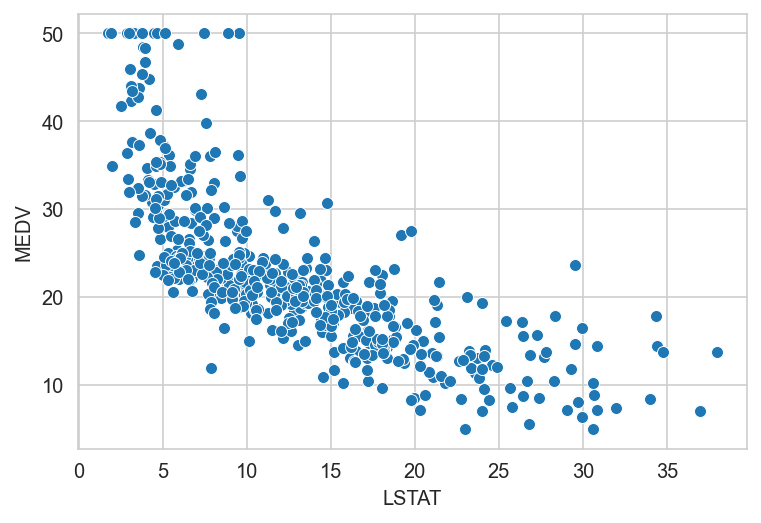

In [34]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df_boston = pd.concat([dfX, dfy], axis=1)

sns.scatterplot(x="LSTAT", y="MEDV", data=df_boston)
plt.show()

위 데이터를 이용해 아무런 변환을 하지 않고 회귀분석을 진행한 결과는 아래와 같다.

In [35]:
model = sm.OLS.from_formula('MEDV ~ LSTAT', data=df_boston)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           5.08e-88
Time:                        12:39:19   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

모형의 성능지표라 할 수 있는 결정계수를 확인한 결과 0.544 라는 값을 확인할 수 있다.

Q-Q 플롯과 옴니버스 정규성 검정 결과를 확인하면 잔차가 정규분포를 따르지 않고 있음을 확인할 수 있다.

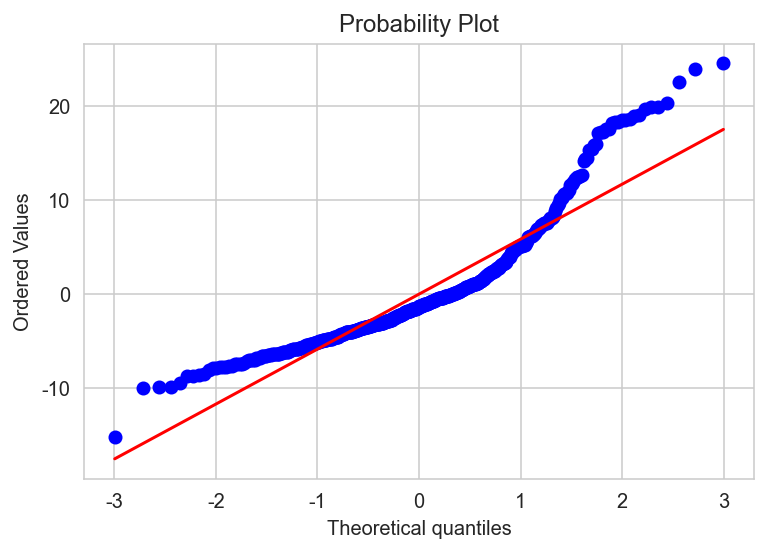

Chi^2       : 137.043
P-value     :  0.000


In [38]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()
test = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

추가적으로 잔차와 독립변수의 관계를 확인한 결과 회귀분석이 올바르게 이루어지지 않고 아직 무언가 예측할 수 있는 여지가 남아있음을 확인할 수 있다.

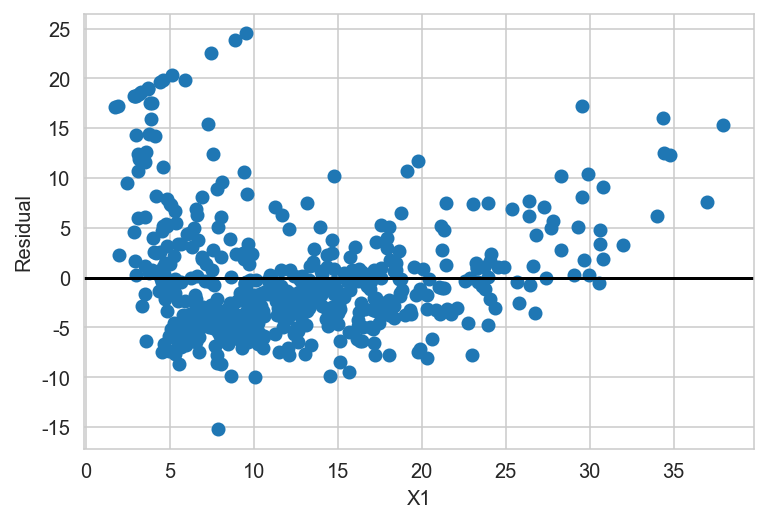

In [42]:
plt.plot(df_boston['LSTAT'], result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

실제로 예측값과 실제 데이터를 비교한 결과 선형모형이 적합하지 않음을 확인할 수 있다.

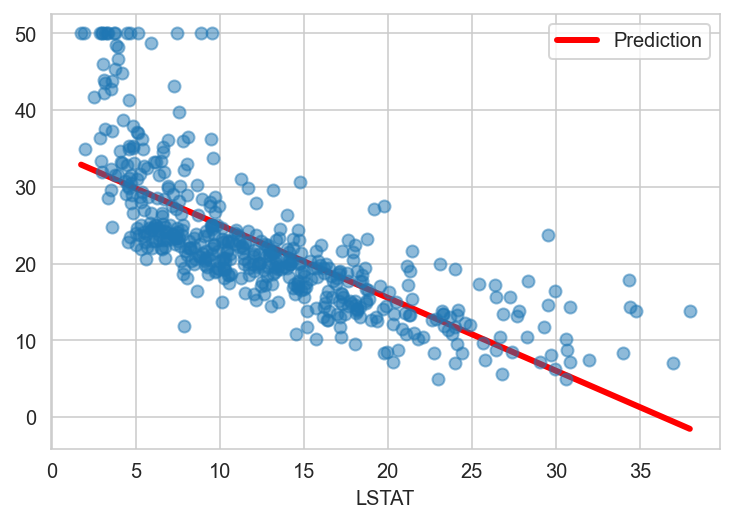

In [46]:
y_hat1 = result.predict(df_boston)
df1 = pd.concat([y_hat1, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df1.columns = ["Prediction", "LSTAT"]
df1.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "o", alpha=0.5)
plt.show()

이러한 문제를 해결하기 위해 LSTAT 값을 제곱한 비선형 독립변수를 추가한 결과를 살펴보자.

In [51]:
model2 = sm.OLS.from_formula('MEDV ~ LSTAT + I(LSTAT ** 2)', data=df_boston)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Mon, 23 Aug 2021   Prob (F-statistic):          1.56e-112
Time:                        12:49:30   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

실제 데이터와 예측값을 비교한 결과 앞선 선형회귀 모형보다 보다 적합한 모형이 된 것을 확인할 수 있다.

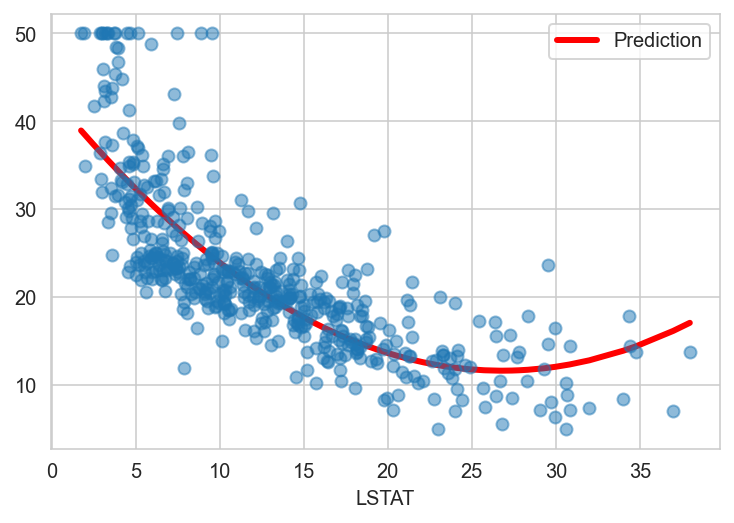

In [53]:
y_hat2 = result2.predict(df_boston)
df2 = pd.concat([y_hat2, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df2.columns = ["Prediction", "LSTAT"]
df2.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "o", alpha=0.5)
plt.show()

잔차의 분포가 완벽한 정규분포를 이루고 있지는 않지만 앞의 결과보다는 확실히 정규분포에 가까워진것을 확인할 수 있고 독립변수와 잔차의 관계를 확인해보면 직관적으로도 더이상 무언가 예측할 수 있는 여지가 사라진 것을 확인할 수 있다.

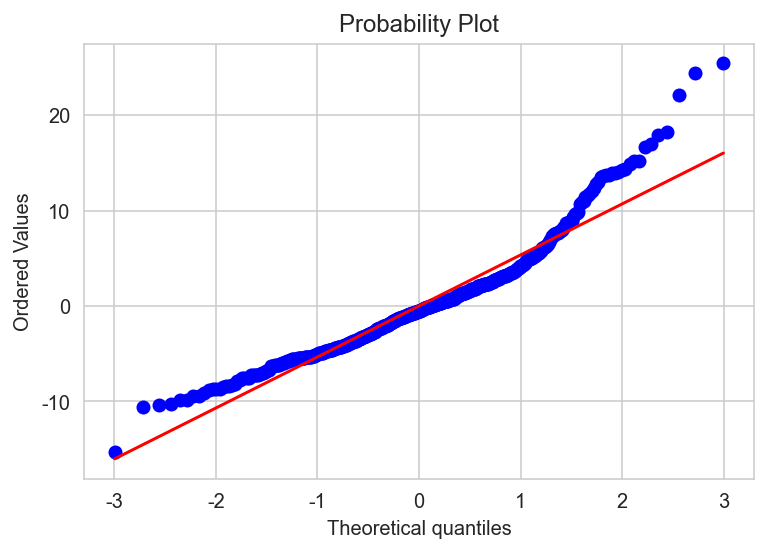

Chi^2       : 107.006
P-value     :  0.000


In [54]:
sp.stats.probplot(result2.resid, plot=plt)
plt.show()
test = sm.stats.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

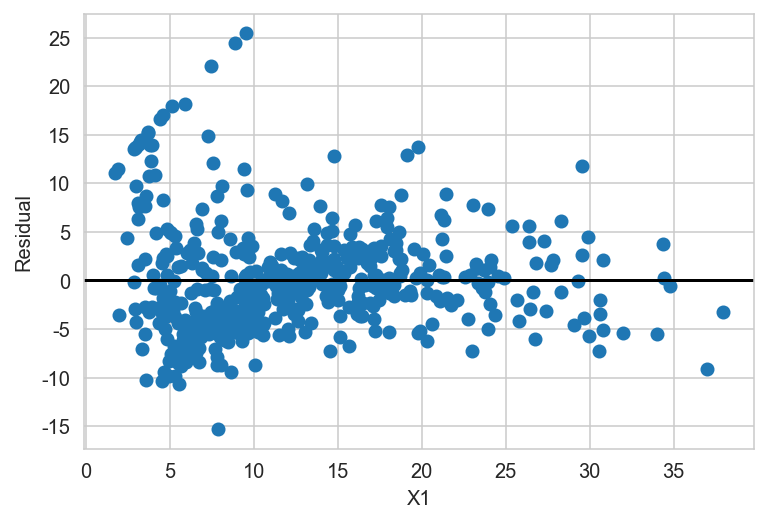

In [55]:
plt.plot(df_boston['LSTAT'], result2.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

# 범주형을 사용한 비선형성

독립변수의 비선형성이 어떤 고차원의 다항식을 따르는 경우 이를 강제로 범주형 값으로 만들어 해결할 수 있다.

아래의 시각화 결과는 종속변수와 독립변수 RM(방의 갯수)의 관계를 시각화 한 결과이다.

이 경우 방의 갯수가 5 ~ 8 사이에는 관계가 선형에 가깝다고 볼 수 있지만 방의 갯수가 아주 작거나 많은 경우 비선형적인 모습을 확인할 수 있다.

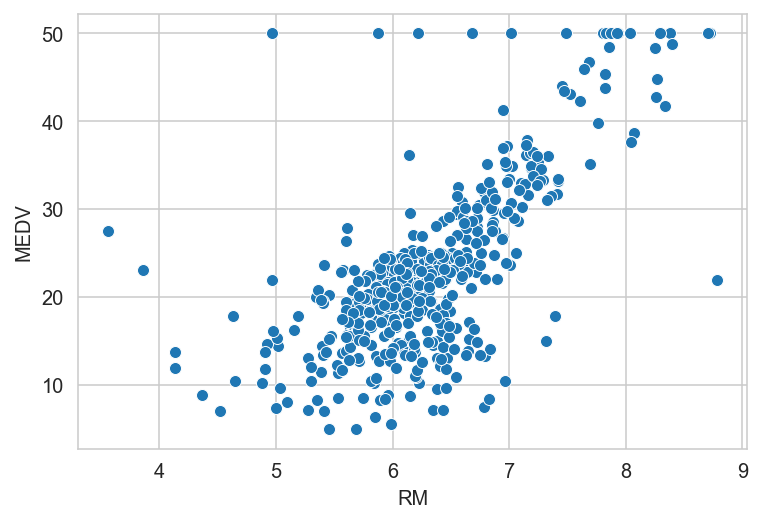

In [56]:
sns.scatterplot(x="RM", y="MEDV", data=df_boston)
plt.show()

In [57]:
model3 = sm.OLS.from_formula("MEDV ~ RM", data=df_boston)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           2.49e-74
Time:                        12:58:34   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

이 경우 RM 독립변수를 강제로 정수로 rounding하여 RM변수가 가지는 비선형성을 잡을 수 있다.

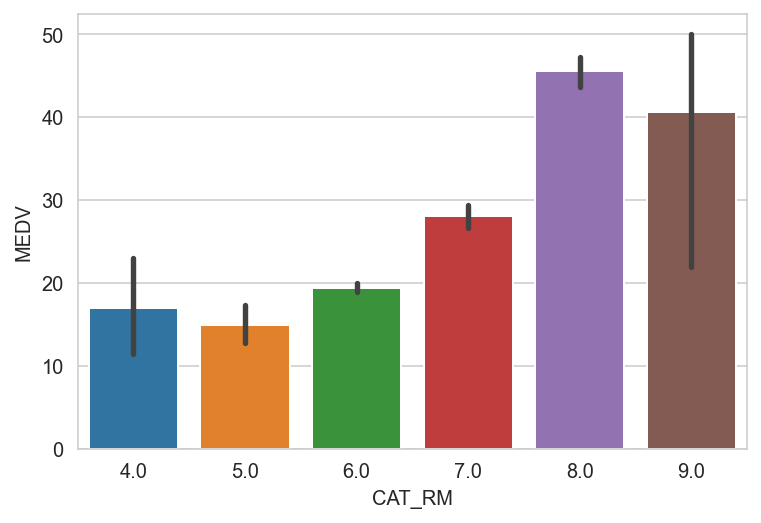

In [58]:
rooms = np.arange(3, 10)
labels = [str(r) for r in rooms[:-1]]
df_boston["CAT_RM"] = np.round(df_boston.RM)

sns.barplot(x="CAT_RM", y="MEDV", data=df_boston)
plt.show()

즉, RM변수를 더미화시켜 비선형 상수항으로 모형화 하는 것이다.

In [59]:
model4 = sm.OLS.from_formula("MEDV ~ C(np.round(RM))", data=df_boston)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     115.8
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           3.57e-81
Time:                        12:59:41   Log-Likelihood:                -1645.6
No. Observations:                 506   AIC:                             3303.
Df Residuals:                     500   BIC:                             3329.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17

실제로 모델의 성능이 더 향상된 것을 확인할 수 있다.

## 종속변수 변형

LSTAT 독립변수를 이용해 집값을 예측하는 모형의 예측값과 실제값의 관계를 시각화 하면 다음과 같다.

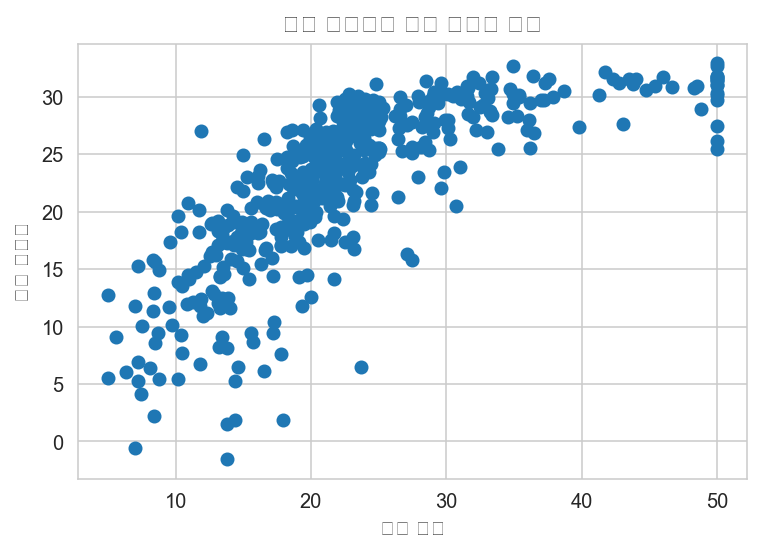

In [62]:
plt.scatter(boston.target, y_hat1)
plt.xlabel(u"실제 집값")
plt.ylabel(u"집값 예측치")
plt.title("집값 예측치와 실제 집값의 관계")
plt.show()

만약 회귀분석이 올바르게 수행되었다면 예측치와 실제 타겟값은 선형적인 모습이 그려져야 한다. 하지만 실제로 위의 결과는 제곱근이나 로그 그래프와 유사하기 때문에 trial error를 통해 여러가지 모형을 비교해보자.

In [63]:
model11 = sm.OLS.from_formula("np.sqrt(MEDV) ~ LSTAT", data=df_boston)
result11 = model11.fit()
print(result11.summary())

                            OLS Regression Results                            
Dep. Variable:          np.sqrt(MEDV)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     789.7
Date:                Mon, 23 Aug 2021   Prob (F-statistic):          3.09e-105
Time:                        13:03:35   Log-Likelihood:                -445.65
No. Observations:                 506   AIC:                             895.3
Df Residuals:                     504   BIC:                             903.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9499      0.053    112.374      0.0

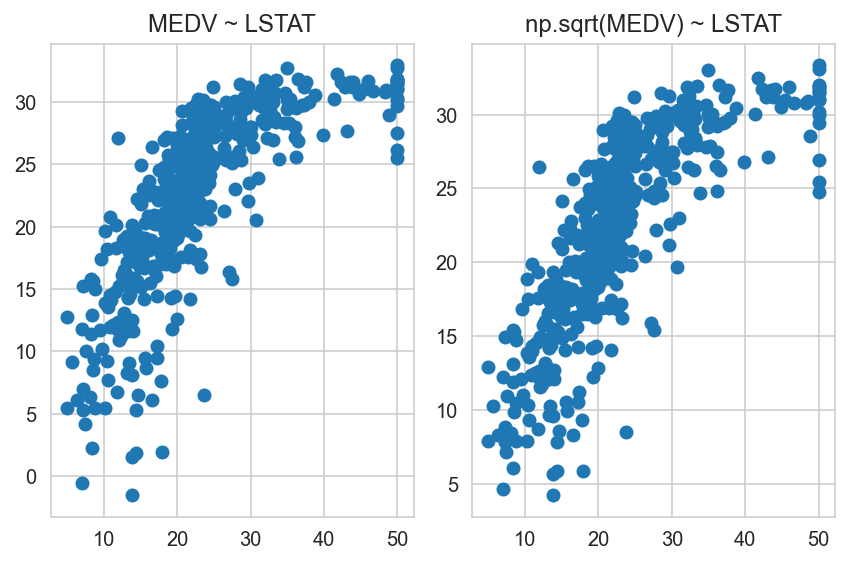

In [64]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, (result11.predict(df_boston))**2)
plt.title("np.sqrt(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [65]:
model12 = sm.OLS.from_formula("np.log(MEDV) ~ LSTAT", data=df_boston)
result12 = model12.fit()
print(result12.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     928.1
Date:                Mon, 23 Aug 2021   Prob (F-statistic):          2.23e-116
Time:                        13:03:48   Log-Likelihood:               -0.57634
No. Observations:                 506   AIC:                             5.153
Df Residuals:                     504   BIC:                             13.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6176      0.022    164.654      0.0

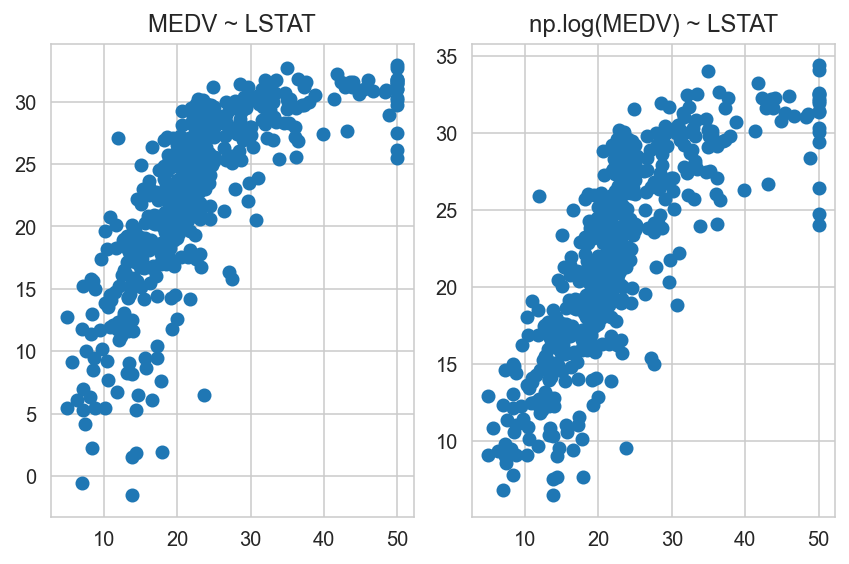

In [66]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result12.predict(df_boston)))
plt.title("np.log(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [67]:
model13 = sm.OLS.from_formula("np.log(MEDV) ~ np.log(LSTAT)", data=df_boston)
result13 = model13.fit()
print(result13.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 23 Aug 2021   Prob (F-statistic):          7.32e-126
Time:                        13:03:56   Log-Likelihood:                 21.325
No. Observations:                 506   AIC:                            -38.65
Df Residuals:                     504   BIC:                            -30.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3618      0.042    103.603

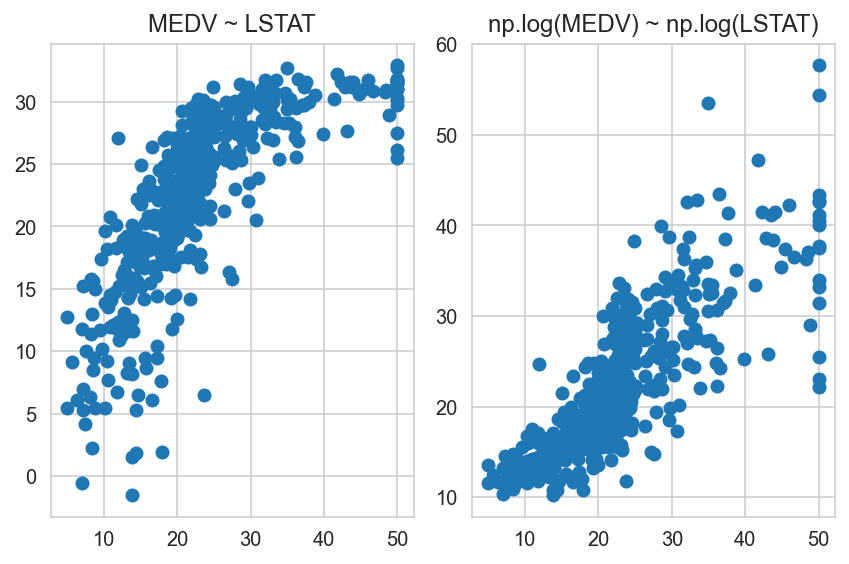

In [68]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result13.predict(df_boston)))
plt.title("np.log(MEDV) ~ np.log(LSTAT)")
plt.tight_layout()
plt.show()


최종적으로 종속변수와 독립변수에 모두 로그를 취한 모형이 가장 좋은것을 확인할 수 있다.

실제로 MEDV, LSTAT, RM 세가지 변수를 이용해 회귀분석을 진행하는데 아무런 수정을 하지 않은 경우와 변수를 수정한 경우의 성능을 비교해보면 다음과 같이 결정계수와 F통계량 유의확률값이 좋아진 것을 확인할 수 있다.

In [85]:
model_final = sm.OLS.from_formula('MEDV ~ LSTAT + RM', data=df_boston)
result_final = model_final.fit()
print(result_final.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     444.3
Date:                Mon, 23 Aug 2021   Prob (F-statistic):          7.01e-112
Time:                        13:10:21   Log-Likelihood:                -1582.8
No. Observations:                 506   AIC:                             3172.
Df Residuals:                     503   BIC:                             3184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3583      3.173     -0.428      0.6

In [88]:
model_final = sm.OLS.from_formula('scale(np.log(MEDV)) ~ scale(LSTAT) + scale(I(LSTAT ** 2)) +  C(np.round(RM))', data=df_boston)
result_final = model_final.fit()
print(result_final.summary())

                             OLS Regression Results                            
Dep. Variable:     scale(np.log(MEDV))   R-squared:                       0.724
Model:                             OLS   Adj. R-squared:                  0.720
Method:                  Least Squares   F-statistic:                     186.4
Date:                 Mon, 23 Aug 2021   Prob (F-statistic):          1.05e-134
Time:                         13:11:02   Log-Likelihood:                -392.53
No. Observations:                  506   AIC:                             801.1
Df Residuals:                      498   BIC:                             834.9
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

# 시간 독립변수의 영향

In [3]:
data = sm.datasets.get_rdataset("elecdaily", package="fpp2")

df_elec = data.data.drop(columns=["WorkDay", "Temperature"])
df_elec["Date"] = pd.date_range("2014-1-1", "2014-12-31")
df_elec.tail()

,Demand,Date
360,173.727990,2014-12-27
361,188.512817,2014-12-28
362,191.273009,2014-12-29
363,186.240144,2014-12-30
364,186.370181,2014-12-31


In [4]:
import datetime as dt

df_elec["Ordinal"] = df_elec.Date.map(dt.datetime.toordinal)
df_elec["Timestamp"] = df_elec.Date.map(dt.datetime.timestamp)
df_elec.tail()

,Demand,Date,Ordinal,Timestamp
360,173.727990,2014-12-27,735594,1.419606e+09
361,188.512817,2014-12-28,735595,1.419692e+09
362,191.273009,2014-12-29,735596,1.419779e+09
363,186.240144,2014-12-30,735597,1.419865e+09
364,186.370181,2014-12-31,735598,1.419952e+09


In [5]:
model5 = sm.OLS.from_formula("Demand ~ scale(Ordinal)", data=df_elec)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     11.58
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           0.000739
Time:                        13:24:45   Log-Likelihood:                -1709.7
No. Observations:                 365   AIC:                             3423.
Df Residuals:                     363   BIC:                             3431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        221.2775      1.374    160.

In [6]:
df_elec["Year"] = df_elec.Date.dt.year
df_elec["Month"] = df_elec.Date.dt.month
df_elec["DayOfYear"] = df_elec.Date.dt.dayofyear
df_elec["DayOfMonth"] = df_elec.Date.dt.daysinmonth
df_elec["DayOfWeek"] = df_elec.Date.dt.dayofweek
df_elec["WeekOfYear"] = df_elec.Date.dt.weekofyear
df_elec["Weekday"] = df_elec.Date.dt.weekday
df_elec["IsMonthStart"] = df_elec.Date.dt.is_month_start
df_elec["IsMonthEnd"] = df_elec.Date.dt.is_month_end
df_elec.tail()

C:\Users\Kim\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,Demand,Date,Ordinal,Timestamp,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,WeekOfYear,Weekday,IsMonthStart,IsMonthEnd
360,173.727990,2014-12-27,735594,1.419606e+09,2014,12,361,31,5,52,5,False,False
361,188.512817,2014-12-28,735595,1.419692e+09,2014,12,362,31,6,52,6,False,False
362,191.273009,2014-12-29,735596,1.419779e+09,2014,12,363,31,0,1,0,False,False
363,186.240144,2014-12-30,735597,1.419865e+09,2014,12,364,31,1,1,1,False,False
364,186.370181,2014-12-31,735598,1.419952e+09,2014,12,365,31,2,1,2,False,True


In [7]:
feature_names = df_elec.columns.tolist()
feature_names.remove("Demand")
feature_names.remove("Date")

formula = """
Demand ~ scale(Ordinal) + C(Month) + DayOfYear + 
         C(DayOfMonth) + C(DayOfWeek) + C(Weekday) + C(IsMonthStart) + C(IsMonthEnd)
"""
model6 = sm.OLS.from_formula(formula, data=df_elec)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     19.98
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           4.74e-46
Time:                        13:24:56   Log-Likelihood:                -1574.8
No. Observations:                 365   AIC:                             3192.
Df Residuals:                     344   BIC:                             3273.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# 주기성을 가지는 독립변수

In [8]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()

feature_names = ["Aspect", "Hillshade_9am"]
df_covtype = pd.DataFrame(covtype.data[:, [1, 6]], columns=feature_names)
df_covtype = df_covtype.sample(10000, random_state=0)  # 편의상 10,000개 표본 추출
df_covtype.tail()

,Aspect,Hillshade_9am
77297,90.0,235.0
103214,38.0,220.0
459385,79.0,241.0
159359,58.0,225.0
565783,91.0,240.0


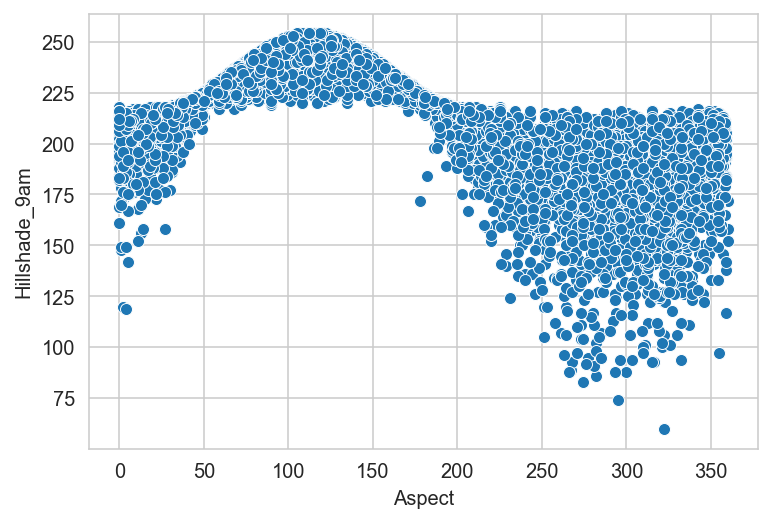

In [9]:
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.show()

비선형성을 만들기 위해 강제로 제곱, 세제곱은 추가하였다.

In [10]:
model7 = sm.OLS.from_formula(
    "Hillshade_9am ~ Aspect + I(Aspect**2) + I(Aspect**3)", 
    data=df_covtype
)
result7 = model7.fit()
print(result7.summary())

                            OLS Regression Results                            
Dep. Variable:          Hillshade_9am   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     7974.
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:26:20   Log-Likelihood:                -40905.
No. Observations:               10000   AIC:                         8.182e+04
Df Residuals:                    9996   BIC:                         8.185e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        187.0395      0.485    385.

In [11]:
df_test = pd.DataFrame([[0], [360]], columns=["Aspect"])
df_result7 = result7.predict(df_test)
df_result7

0    187.039453
1    193.002560
dtype: float64

하지만 0도에서 360에서는 완벽하게 맞춰지지 않은 것을 확인할 수 있다.

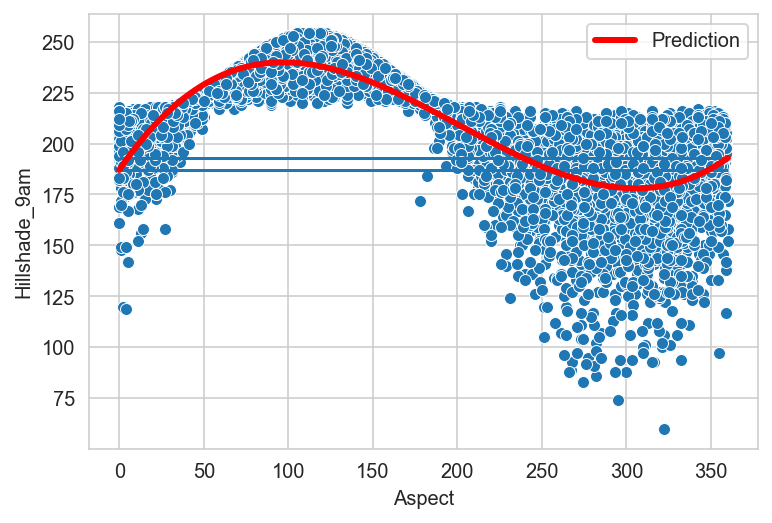

In [12]:
y_hat7 = result7.predict(df_covtype)
df7 = pd.concat([y_hat7, df_covtype.Aspect], axis=1).sort_values("Aspect")
df7.columns = ["Prediction", "Aspect"]
df7.plot(x="Aspect", style="r-", lw=3)
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.hlines(df_result7.values[0], 0, 360)
plt.hlines(df_result7.values[1], 0, 360)
plt.show()


따라서 각도를 코사인, 사인값으로 쪼개서 두 변수로 만들어준다면 다음과 같다.

In [13]:
f = 2.0 * np.pi / 360

model8 = sm.OLS.from_formula("""
Hillshade_9am ~ 
np.cos(f * Aspect) +
np.sin(f * Aspect)
""", data=df_covtype
)
result8 = model8.fit()
print(result8.summary())

                            OLS Regression Results                            
Dep. Variable:          Hillshade_9am   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                 1.334e+04
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:26:21   Log-Likelihood:                -40515.
No. Observations:               10000   AIC:                         8.104e+04
Df Residuals:                    9997   BIC:                         8.106e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            208.8444      0

In [14]:
df_result8 = result8.predict(df_test)
df_result8

0    196.069868
1    196.069868
dtype: float64

이 경우 정확하게 주기성을 표시할 수 있다. 

> 이처럼 각도의 경우는 사인과 코사인을 이용해 두개의 변수로 나누어서 모델링하는 방법을 이용할 수 있다.

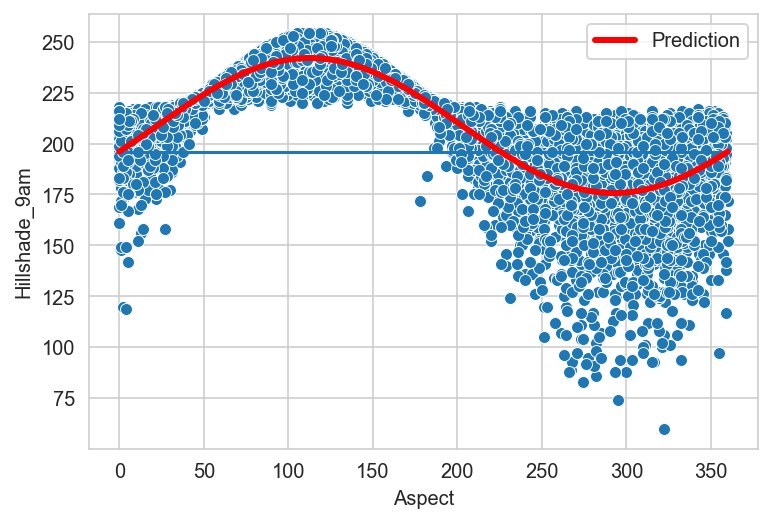

In [15]:
y_hat8 = result8.predict(df_covtype)
df8 = pd.concat([y_hat8, df_covtype.Aspect], axis=1).sort_values("Aspect")
df8.columns = ["Prediction", "Aspect"]
df8.plot(x="Aspect", style="r-", lw=3)
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.hlines(df_result8.values[0], 0, 360)
plt.hlines(df_result8.values[1], 0, 360)
plt.show()